Uploading the kaggle API key 

In [95]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"shoebabrar","key":"5797d4787b1a9fb4efe8616e803d8560"}'}

Making a directory and copying the kaggle api file into the direcory

In [96]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Downloading the dataset from kaggle

In [97]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

hard-hat-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


Extracting the images and annotations from the zip file

In [98]:
!unzip hard-hat-detection.zip

Archive:  hard-hat-detection.zip
replace annotations/hard_hat_workers0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Defining the file paths of images and annotations

In [99]:
file_path = '/content/'
ann_path = file_path + 'annotations/'
img_path = file_path + 'images/'

Sorting the images for consistency

To get images, the extension of the filename is checked to be jpg

To get annotations, the extension of the filename is checked to be xml

In [100]:
from pathlib import Path

path_annotations = []
for i in Path(ann_path).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations)

path_images = []
for i in Path(img_path).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images)

Split data : 80% Train, 20% Val


In [101]:
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:5000]
path_val_images = path_images[4000:5000]

To store the splitted data making directories train, val

In [102]:
import os
os.makedirs('./train', exist_ok = True)
os.makedirs('./val', exist_ok = True)

Using shutil.copy, copying images & xml annotations to respective train and val directories

In [103]:
import shutil
from tqdm import tqdm

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, './train/' + path_img.parts[-1])
    shutil.copy(path_annot, './train/' + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, './val/' + path_img.parts[-1])
    shutil.copy(path_annot, './val/' + path_annot.parts[-1])

4000it [00:09, 400.05it/s]
1000it [00:02, 395.17it/s]


## Installs and Imports

In [104]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Lets import the libraries

In [105]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


## Dataset 

Lets build the hard hat images dataset!

In [106]:
# defining the files directory and testing directory
files_dir = '/content/train/'
test_dir = '/content/val/'


class HardHatDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'helmet','head','person']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = HardHatDataset(files_dir, 416, 416)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  4000 

(416, 416, 3) 
 {'boxes': tensor([[219.0000, 118.2843, 242.0000, 140.3374],
        [219.0000,   8.0193, 242.0000,  30.0723]]), 'labels': tensor([1, 1]), 'area': tensor([507.2194, 507.2192]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([78])}



Now see, what our data looks like.

# Visualization

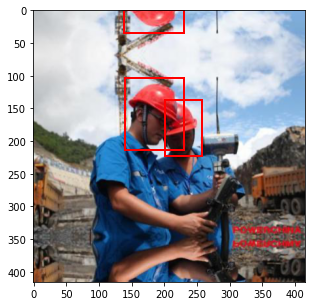

In [107]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

# Model

We will define a function for loading the model. We will call it later

In [108]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Augmentations

This is where we can apply augmentations to the image. 

Here I have added random flip transform, feel free to customize it as you feel



In [109]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

Now lets prepare datasets and dataloaders for training and testing.

In [110]:
# use our dataset and defined transformations
dataset = HardHatDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = HardHatDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Training

Let's prepare the model for training

In [111]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let the training begin!

In [112]:
# training for 5 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/320]  eta: 0:17:37  lr: 0.000041  loss: 1.7599 (1.7599)  loss_classifier: 1.3026 (1.3026)  loss_box_reg: 0.2398 (0.2398)  loss_objectness: 0.1972 (0.1972)  loss_rpn_box_reg: 0.0203 (0.0203)  time: 3.3047  data: 1.4588  max mem: 8740
Epoch: [0]  [ 10/320]  eta: 0:10:33  lr: 0.000354  loss: 1.5130 (1.4757)  loss_classifier: 1.1062 (1.0308)  loss_box_reg: 0.2330 (0.2357)  loss_objectness: 0.1828 (0.1858)  loss_rpn_box_reg: 0.0202 (0.0234)  time: 2.0432  data: 0.1695  max mem: 8740
Epoch: [0]  [ 20/320]  eta: 0:09:44  lr: 0.000668  loss: 1.0871 (1.1962)  loss_classifier: 0.5092 (0.7363)  loss_box_reg: 0.2559 (0.2908)  loss_objectness: 0.1284 (0.1437)  loss_rpn_box_reg: 0.0201 (0.0253)  time: 1.8800  data: 0.0427  max mem: 8740
Epoch: [0]  [ 30/320]  eta: 0:09:09  lr: 0.000981  loss: 0.8394 (1.1195)  loss_classifier: 0.3831 (0.6291)  loss_box_reg: 0.4220 (0.3374)  loss_objectness: 0.0819 (0.1281)  loss_rpn_box_reg: 0.0184 (0.0249)  time: 1.8158  data: 0.0403  max mem: 8740


# Testing our Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [114]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  9
real #boxes:  4


EXPECTED OUTPUT


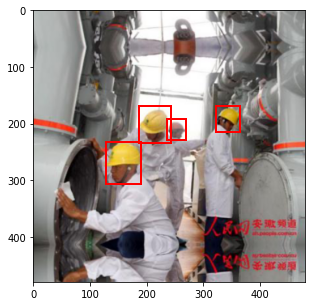

In [115]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [117]:
CLASS_NAME = [_, 'helmet','head','person']

In [118]:
import xml.etree.ElementTree as ET

In [121]:
detection_threshold = 0.8

In [123]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('./val/', Path(img_path).parts[-1][:-4] + '.xml')
    
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes, labels

In [124]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='red'
    elif lbl=='head': # 2=head
        color_lbl='yellow'
    else:
        color_lbl='blue'
    
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)
    

def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.


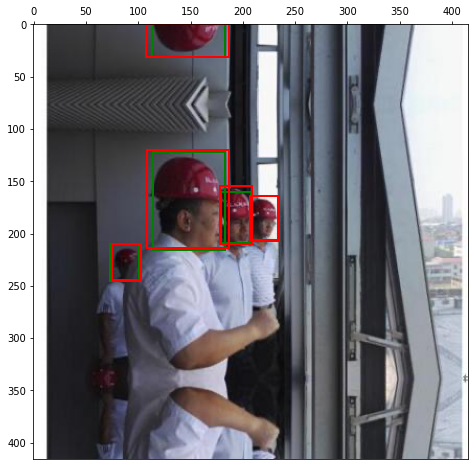

In [125]:

image = plt.imread('/content/val/hard_hat_workers4599.png')
img = image.copy()

# bring color channels to front
img = np.transpose(img, (2, 0, 1)).astype(np.float32)

# convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
    
# add batch dimension
img = torch.unsqueeze(img, 0)
with torch.no_grad(): #forward pass
    outputs = model(img.to(device))

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
test_img = '/content/val/hard_hat_workers4599.xml'
# draw actual bounding boxes (to compare with predicted boxes)
act_box, act_lbl = get_box_lbl(test_img) #get actual boxes & labels
ax = plot_act(image, act_box)

# carry further only if there are detected boxes
if len(outputs[0]['boxes']) > 0:
    boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
    scores = outputs[0]['scores'].data.numpy()
    lbls = outputs[0]['labels'].data.numpy()

    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores > detection_threshold].astype(np.int32)
    lbls = lbls[scores > detection_threshold].astype(np.int32)
    pred_boxes = boxes.copy()
    
    # get all the predicited class names
    pred_class = [CLASS_NAME[i] for i in lbls]

    # draw predicted boxes (to compare with actuals)
    plot_pred(ax, pred_boxes, pred_class)
print("Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.")